# Import functions for all processing
Put this notebook inside passive_interval_oddball_202412 project folder. The fllowing is the same as main.py at the beginning.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os

from modules import Trialization
from modules import StatTest
from modules.ReadResults import read_ops
from modules.ReadResults import read_all
from modules.ReadResults import clean_memap_path

def combine_session_config_list(session_config_list):
    list_session_data_path = []
    for sc in session_config_list['list_config']:
        list_session_data_path += [
            os.path.join('results', sc['session_folder'], n)
            for n in sc['list_session_name'].keys()]
    list_session_name = [sc['list_session_name'] for sc in session_config_list['list_config']]
    list_session_name = {k: v for d in list_session_name for k, v in d.items()}
    session_config_list['list_session_name'] = list_session_name
    session_config_list['list_session_data_path'] = list_session_data_path
    return session_config_list

def get_roi_sign(significance, roi_id):
    r = significance['r_standard'][roi_id] +\
        significance['r_change'][roi_id] +\
        significance['r_oddball'][roi_id]
    return r

import visualization1_FieldOfView
import visualization2_3331Random
import visualization3_1451ShortLong
import visualization4_4131FixJitterOdd
from webpage import pack_webpage_main

# Define the folder name to the sessions you want to process

## Folder structure

This notebook should be SomeWhere/passive_interval_oddball_202412/quick_start.ipynb.

The data should be SomeWhere/passive_interval_oddball_202412/SubjectName/SessionName.

In this example, we use 1 session from the random paradigm, and the session data is SomeWhere/passive_interval_oddball_202412/test/VTYH02_PPC_20250109_3331Random.

## How to set the sessions going into the analysis

Change list_session_name elements in session_config_test to add or exclude sessions. No need to change anything else at this time.

## It works for both single and cross subject analysis

Here, session_config_test is for cross subject analysis, while session_config_list_test specify the info for one subject. If you are running single subject analysis, list_config in session_config_list_test should have only 1 element for that subject.

In [7]:
session_config_test = {
        'list_session_name' : {
            'VTYH02_PPC_20250109_3331Random' : 'random',
            #'VTYH02_PPC_20250116_1451ShortLong' : 'short_long',
            #'VTYH02_PPC_20250122_4131FixJitterOdd' : 'fix_jitter_odd',
            },
        'session_folder' : 'test',
        'sig_tag' : 'all',
        'force_label' : None,
        }
session_config_list_test = {
    'list_config': [
        session_config_test,
        ],
    'label_names' : {
        '-1':'Exc',
        '1':'Inh_VIP',
        '2':'Inh_SST',
        },
    'subject_name' : 'test',
    'output_filename' : 'test_PPC_passive.html'
    }

Run this to get session configurations. There is only 1 session so the list will have only 1 element. The list structure is using for cross session or cross subject settings.

In [11]:
session_config_list = combine_session_config_list(session_config_list_test)
list_ops = read_ops(session_config_list['list_session_data_path'])
print(session_config_list)
print(f'number of sessions: {len(list_ops)}')

{'list_config': [{'list_session_name': {'VTYH02_PPC_20250109_3331Random': 'random'}, 'session_folder': 'test', 'sig_tag': 'all', 'force_label': None}], 'label_names': {'-1': 'Exc', '1': 'Inh_VIP', '2': 'Inh_SST'}, 'subject_name': 'test', 'output_filename': 'test_PPC_passive.html', 'list_session_name': {'VTYH02_PPC_20250109_3331Random': 'random'}, 'list_session_data_path': ['results\\test\\VTYH02_PPC_20250109_3331Random']}
number of sessions: 1


# Reading data results

Run the following to do trialization and statistical test if it is not done yet. Otherwise, you can skip this.

Ignore the statistical test results for now.

In [13]:
for i in range(len(list_ops)):
    Trialization.run(list_ops[i])
for i in range(len(list_ops)):
    StatTest.run(list_ops[i])

Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data
Aligning neural population response


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1996/1996 [00:00<00:00, 4110.46it/s]


Running statistics test
249/253 ROIs responsive to standard
249/253 ROIs responsive to change
249/253 ROIs responsive to oddball


Now you can read all results for analysis as follows.

In [14]:
[list_labels, list_masks, list_vol, list_dff,
 list_neural_trials, list_move_offset, list_significance
] = read_all(session_config_list)

Reading subject 1/1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


# Neural data alignment

We are using classes for modularizations. All the following codes are drawed from fig4_3331Random.py.

## Import functions and run alignment

This is the same when initiating a plotter class.

In [15]:
import numpy as np
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA

from modules.Alignment import run_get_stim_response
from modeling.clustering import clustering_neu_response_mode
from modeling.clustering import get_mean_sem_cluster
from modeling.clustering import manual_feature_clustering
from modeling.generative import run_glm_multi_sess
from utils import get_norm01_params
from utils import get_bin_idx
from utils import get_mean_sem
from utils import get_mean_sem_win
from utils import get_neu_trial
from utils import get_frame_idx_from_time
from utils import get_epoch_idx
from utils import get_isi_bin_neu
from utils import get_neu_sync
from utils import get_cmap_color
from utils import apply_colormap
from utils import adjust_layout_neu
from utils import adjust_layout_heatmap
from utils import add_legend
from utils import add_heatmap_colorbar
from utils import utils_basic

timescale = 1.0
n_sess = len(list_neural_trials)
l_frames = int(100*timescale)
r_frames = int(80*timescale)
list_labels = list_labels
list_neural_trials = list_neural_trials
alignment = run_get_stim_response(
        list_neural_trials, l_frames, r_frames, expected='none')
list_stim_labels = alignment['list_stim_labels']
list_significance = list_significance
bin_win = [450,2550]
bin_num = 3
n_clusters = 5
max_clusters = 10
d_latent = 3

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1980/1980 [00:00<00:00, 5063.57it/s]


All the trialized neural data are in alignment. It has the following keys to access. Each element in alignment is a list. This list has the results for multiple sessions. 

In [16]:
print(alignment.keys())

dict_keys(['list_stim_labels', 'list_neu_seq', 'neu_time', 'list_stim_seq', 'list_stim_value', 'stim_time', 'list_led_value', 'list_pre_isi'])


### Neural data
list_neu_seq is the neural data after alignment on each image onset. It has l_frames before the onset and r_frames after onset. Each element in this list represents 1 session, and has the shape of $n_{trials} \times n_{neurons} \times n_{times}$.

neu_time is the time stamps of the neural data with the shape of $n_{times}$.

In [27]:
print('frames before onset: {}'.format(l_frames))
print('frames after onset: {}'.format(r_frames))
print('shape of aligned neural data in a session: {}'.format(alignment['list_neu_seq'][0].shape))
print('shape of aligned neural timestamps in a session: {}'.format(alignment['neu_time'].shape))

frames before onset: 100
frames after onset: 80
shape of aligned neural data in a session: (1980, 253, 180)
shape of aligned neural timestamps in a session: (180,)


### Image trial data

list_stim_labels is for accessing trial specific neural data. It marks the information for each image (trial). Each row represents 1 image.

* row 0: stim start.
* row 1: stim end.
* row 2: img_seq_label.
* row 3: standard_types.
* row 4: fix_jitter_types.
* row 5: oddball_types.
* row 6: random_types.
* row 7: opto_types.

Now show the first 5 image here.

In [28]:
print(alignment['list_stim_labels'][0][:5,:])

[[3.27303e+04 3.29284e+04 4.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00]
 [3.37344e+04 3.39367e+04 4.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00]
 [3.61427e+04 3.63409e+04 3.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00]
 [3.70844e+04 3.72825e+04 3.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00]
 [3.88510e+04 3.90492e+04 2.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00]]


The stimulus timing for one trial has been already proceesed in list_stim_seq. It has multiple stimulus onset and end before and after the alignment center after trial averaged.

Now show the stimulus timing for the 5th aligned trial. 

In [31]:
print(alignment['list_stim_seq'][0][5,:])

[[-16499.8 -16301.6]
 [-14812.3 -14614.1]
 [-12191.5 -11993.4]
 [-11420.7 -11222.5]
 [ -9070.7  -8872.5]
 [ -7429.   -7230.9]
 [ -6424.9  -6222.6]
 [ -4016.6  -3818.4]
 [ -3074.9  -2876.8]
 [ -1308.3  -1110.1]
 [     0.     202.4]
 [  2475.    2677.3]
 [  3266.7   3469. ]
 [  4166.6   4368.9]
 [  5374.9   5577.2]
 [  6858.3   7056.4]
 [  7754.1   7956.4]
 [  9983.3  10181.4]
 [ 11170.7  11373. ]
 [ 13791.5  13989.6]
 [ 15712.3  15914.6]]


The center stimulus index for alignment can be accessed similar as the following. By setting the number around c_idx you can access stimulus before or after it.

In [36]:
stim_seq = alignment['list_stim_seq'][0][5,:]
c_idx = int(stim_seq.shape[0]/2)
print('onset and end of the aligned stimulus: {}'.format(stim_seq[c_idx,:]))
print('onset and end of the stimlus before center: {}'.format(stim_seq[c_idx-1,:]))
print('onset and end of the stimulus after center: {}'.format(stim_seq[c_idx+1,:]))

onset and end of the aligned stimulus: [  0.  202.4]
onset and end of the stimlus before center: [-1308.3 -1110.1]
onset and end of the stimulus after center: [2475.  2677.3]


list_pre_isi is the interval between the center image and the one before it.

Now show the interval before the 5th alignment stimulus.

In [40]:
print('isi before image: {}'.format(alignment['list_pre_isi'][0][5]))

isi before image: 1110.1000000000058


## Accessing trial averaged data

Use get_neu_trial defined in passive_interval_oddball_202412/utils.py to access trials with specific trial labels. Set cate to the neuron categories as a list, and the trial label as a list.

The list input trial_param is the one to access each trial, where each element gives what are the target label for list_labels.

For example, the following input [[2,3,4,5], None, None, None, [1], [0]] means:
* all 4 image orientation defined in img_seq_label.
* no need to set standard_types.
* no need to set fix_jitter_types.
* no need to set oddball_types.
* image with random isi and random image.
* no opto.

Now show the trial for excitatory neurons during random isi and random image. Be advised, in this setting, the neural data has been averaged across trials and concatenate across sessions.

In [44]:
cate = [-1]
[color0, color1, color2, cmap], [neu_seq, _, stim_seq, stim_value], [neu_labels, neu_sig], [n_trials, n_neurons] = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[2,3,4,5], None, None, None, [1], [0]],
    cate=cate, roi_id=None)

neu_seq gives the target neural data with the shape of $n_{neurons} \times n_{times}$.

In [45]:
print('shape of neural data: {}'.format(neu_seq.shape))

shape of neural data: (211, 180)


Now show the neuron average response to the center stimulus. You need some utility functions defined in utils.py.

In [51]:
def rescale(data, upper, lower):
    data = data.copy()
    data = ( data - np.nanmin(data) ) / (np.nanmax(data) - np.nanmin(data))
    data = data * (upper - lower) + lower
    return data
    
def plot_mean_sem(ax, t, m, s, c, l, a=1.0):
        ax.plot(t, m, color=c, label=l, alpha=a)
        ax.fill_between(t, m - s, m + s, color=c, alpha=0.25, edgecolor='none')
        ax.set_xlim([np.min(t), np.max(t)])

def plot_vol(ax, st, sv, c, u, l):
    v = np.mean(sv, axis=0)
    v = rescale(v, u, l)
    ax.plot(st, v, color=c, lw=0.5, linestyle=':')


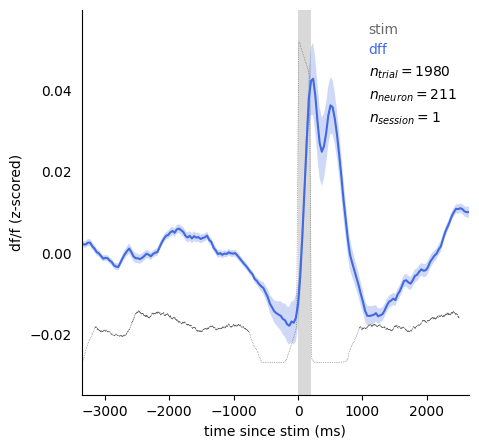

In [68]:
cate = [-1]
roi_id = None
label_names = {'-1':'Exc', '1':'Inh_VIP', '2':'Inh_SST'}

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# collect data.
[color0, _, color2, _], [neu_seq, _, stim_seq, stim_value], _, [n_trials, n_neurons] = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[2,3,4,5], None, None, None, [1], [0]],
    cate=cate, roi_id=roi_id)
mean_neu, sem_neu = get_mean_sem(neu_seq)
# compute bounds.
upper = np.nanmax(mean_neu) + np.nanmax(sem_neu)
lower = np.nanmin(mean_neu) - np.nanmax(sem_neu)
# plot stimulus.
ax.fill_between(
    stim_seq[int(stim_seq.shape[0]/2),:],
    lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
    color=color0, edgecolor='none', alpha=0.25, step='mid')
plot_vol(ax, alignment['stim_time'], stim_value.reshape(1,-1), color0, upper, lower)
# plot neural traces.
plot_mean_sem(ax, alignment['neu_time'], mean_neu, sem_neu, color2, None)
# adjust layout.
adjust_layout_neu(ax)
ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
ax.set_xlabel('time since stim (ms)')
add_legend(ax, [color0, color2], ['stim', 'dff'], n_trials, n_neurons, n_sess, 'upper right')
plt.show()

To access the neural data within a given window, please use get_frame_idx_from_time. It gives you the start and end indice given a window. The function inputs are the time stamp array, the center reference time point, time before the reference, the time after the reference.

Now get the same result but the data within $[-1500, 1000]$ ms, so set the center to $0$, the time before to $-1500$, the time after to $1000$.

In [62]:
win_eval = [-1500, 1000]
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, win_eval[0], win_eval[1])
neu_seq_win = neu_seq[:,l_idx:r_idx]
neu_time_win = alignment['neu_time'][l_idx:r_idx]
print('shape of neural data within the window: {}'.format(neu_seq_win.shape))

shape of neural data within the window: (211, 74)


Now show this window result completely the same as before.

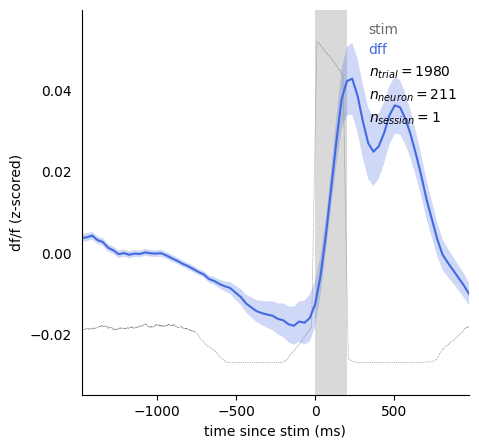

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mean_neu, sem_neu = get_mean_sem(neu_seq_win)
# compute bounds.
upper = np.nanmax(mean_neu) + np.nanmax(sem_neu)
lower = np.nanmin(mean_neu) - np.nanmax(sem_neu)
# plot stimulus.
ax.fill_between(
    stim_seq[int(stim_seq.shape[0]/2),:],
    lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
    color=color0, edgecolor='none', alpha=0.25, step='mid')
plot_vol(ax, alignment['stim_time'], stim_value.reshape(1,-1), color0, upper, lower)
# plot neural traces.
plot_mean_sem(ax, neu_time_win, mean_neu, sem_neu, color2, None)
# adjust layout.
adjust_layout_neu(ax)
ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
ax.set_xlabel('time since stim (ms)')
add_legend(ax, [color0, color2], ['stim', 'dff'], n_trials, n_neurons, n_sess, 'upper right')
plt.show()

Another useful example is to find the neural data given the stimulus. For the random paradigm, the minimal interval is $500$ ms. If you are looking at the data $500$ ms before stimulus onset and $500$ ms after stimulus end, you can first index stim_seq and pass the time to get_frame_idx_from_time as follows.

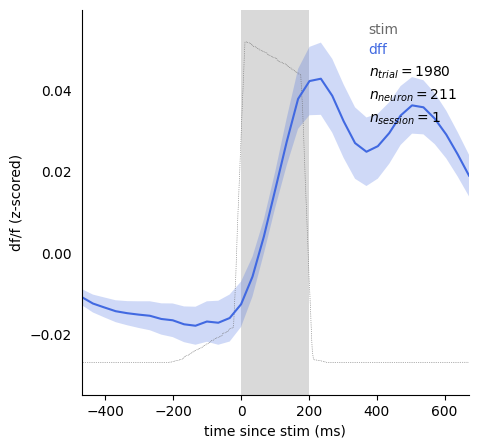

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# collect data.
[color0, _, color2, _], [neu_seq, _, stim_seq, stim_value], _, [n_trials, n_neurons] = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[2,3,4,5], None, None, None, [1], [0]],
    cate=cate, roi_id=roi_id)

# find data points within the required range.
c_idx = int(stim_seq.shape[0]/2)
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, stim_seq[c_idx,0]-500, stim_seq[c_idx,1]+500)
neu_seq_win = neu_seq[:,l_idx:r_idx]
neu_time_win = alignment['neu_time'][l_idx:r_idx]

mean_neu, sem_neu = get_mean_sem(neu_seq_win)
# compute bounds.
upper = np.nanmax(mean_neu) + np.nanmax(sem_neu)
lower = np.nanmin(mean_neu) - np.nanmax(sem_neu)
# plot stimulus.
ax.fill_between(
    stim_seq[int(stim_seq.shape[0]/2),:],
    lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
    color=color0, edgecolor='none', alpha=0.25, step='mid')
plot_vol(ax, alignment['stim_time'], stim_value.reshape(1,-1), color0, upper, lower)
# plot neural traces.
plot_mean_sem(ax, neu_time_win, mean_neu, sem_neu, color2, None)
# adjust layout.
adjust_layout_neu(ax)
ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
ax.set_xlabel('time since stim (ms)')
add_legend(ax, [color0, color2], ['stim', 'dff'], n_trials, n_neurons, n_sess, 'upper right')
plt.show()